In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2023-08-09 04:41:13.040847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 04:41:13.091184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 04:41:13.091982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 04:41:13.961157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = xr.open_dataset('/home/jovyan/shared/data/finalized/sst.nc')

ds['time'] = ds['time'].dt.floor('D')

zarr_new = ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')

zarr_ds

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 149, lon: 181)
Coordinates:
  * lon      (lon) float32 45.0 45.25 45.5 45.75 46.0 ... 89.25 89.5 89.75 90.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 31.0 ... -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 301.2 301.2 301.1
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [3]:
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

# processed_data = preprocess_data(zarr_ds).compute()
processed_data = preprocess_data(zarr_ds)
processed_data

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [4]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [10]:
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import UpSampling2D

def create_improved_model(input_shape=(5, 149, 181, 1)):
    model = Sequential()

    # ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Additional Conv2D layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

model = create_improved_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 149, 181, 32)      38144     
                                                                 
 batch_normalization_6 (Bat  (None, 149, 181, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 149, 181, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 149, 181, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 149, 181, 64)      256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 149, 181, 64)     

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

# Add model_checkpoint to the callbacks list
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[early_stop])

2023-08-09 05:17:44.988270: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2894313080 exceeds 10% of free system memory.
2023-08-09 05:17:51.441877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2894313080 exceeds 10% of free system memory.


Epoch 1/20
168/168 [==============================] - 1475s 9s/step - loss: 0.1340 - mse: 0.1340 - val_loss: 0.8470 - val_mse: 0.8470
Epoch 2/20
168/168 [==============================] - 1471s 9s/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.3478 - val_mse: 0.3478
Epoch 3/20
168/168 [==============================] - 1469s 9s/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.1176 - val_mse: 0.1176
Epoch 4/20
168/168 [==============================] - 1475s 9s/step - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 5/20
168/168 [==============================] - 1478s 9s/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 6/20
168/168 [==============================] - 1478s 9s/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 7/20
168/168 [==============================] - 1482s 9s/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 8/20
168/168 [==============================] - 1472s 9s

In [13]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            sample_2d = np.squeeze(sample)
            plt.imshow(sample_2d, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [14]:
def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    squared_diff = (y_true[mask] - y_pred[mask]) ** 2
    return np.mean(squared_diff)

(5, 149, 181)
(149, 181)
1/1 [==============================] - 0s 270ms/step
(149, 181, 1)


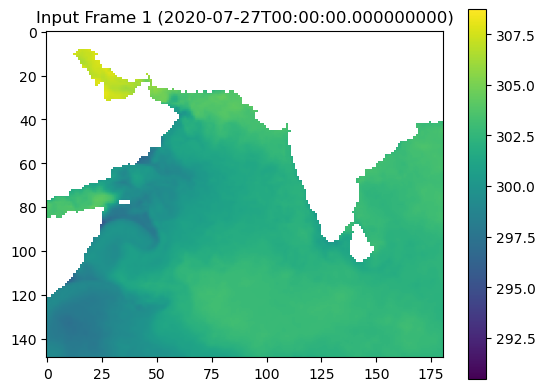

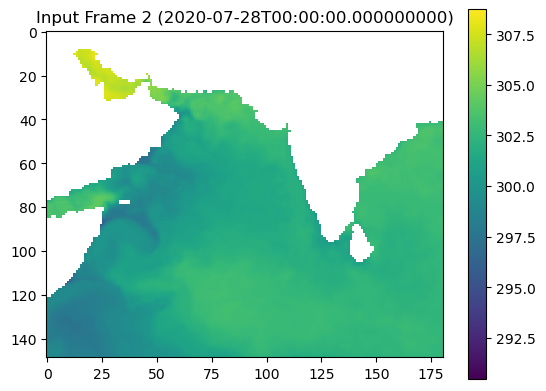

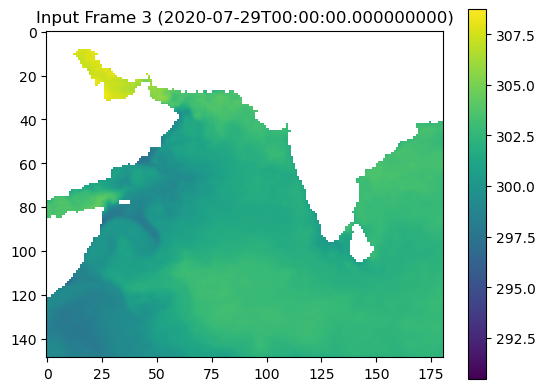

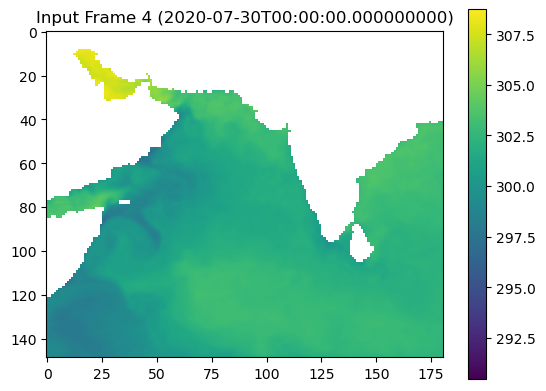

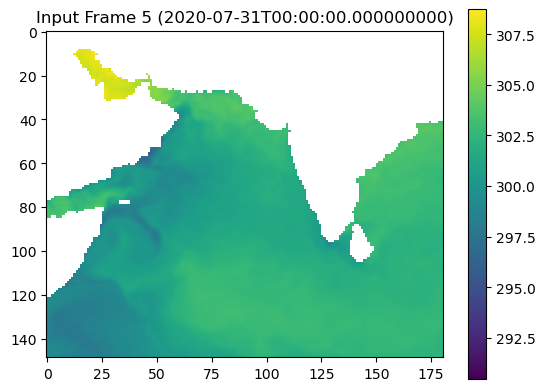

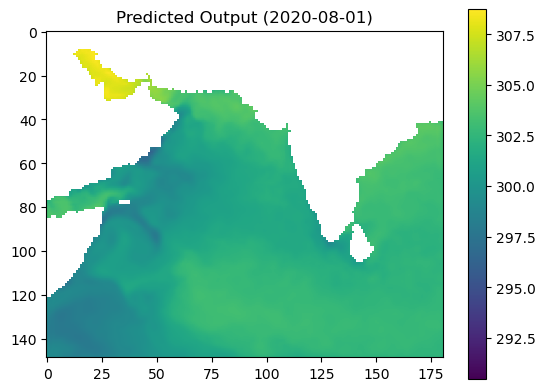

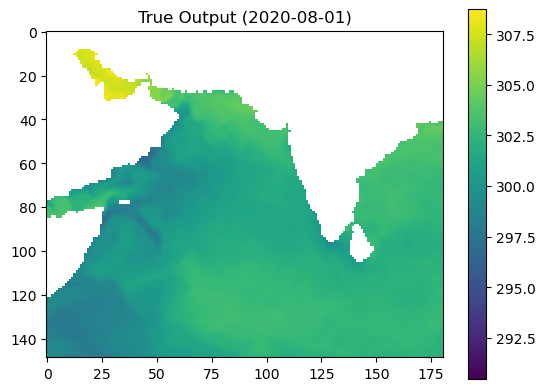

MAE between Predicted Output and True Output: 0.041579801589250565
MAE between Last Input Frame and True Output: 0.03753738850355148


In [15]:
date_to_predict = '2020-08-01'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mse = compute_mse(true_output, predicted_output)
print(f"MSE between Predicted Output and True Output: {predicted_mse}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mse = compute_mse(true_output_2d, last_input_frame_2d)
print(f"MSE between Last Input Frame and True Output: {last_frame_mse}")

In [16]:
model.save('ConvLSTM2_nc_2000-2020.keras')